# HW3: Where is the Röstigraben?

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium

## Data loading and preparation

A first glance at the data gives us usefull information:
* `'Nicht zuteilbar - NA'` => values not classifiable
* `'data not included in P3'` => missing values

Then we can import the data and only keep the relevant columns which are:
* `'University'`
* `'Approved Amount'`

By doing some data wrangling, we observed that out of 76 possible values for `'University'`, a few of them are useless because they cannot help in classifying by Cantons. And that one of the university is located in Italy. So we choose to remove all these rows.  
We also prepared the 26 cantons in a csv file that we can easily load to proceed further.

In [2]:
na = ['Nicht zuteilbar - NA',       # Not classifiable
      'data not included in P3']    # Missing value
df = pd.read_csv('data/P3_GrantExport.csv', delimiter=';', na_values=na, usecols=[7,13])
# Universities not classable or not within Switzerland:
no_chance = ['NPO (Biblioth., Museen, Verwalt.) - NPO',
             'Firmen/Privatwirtschaft - FP',
             'Weitere Institute - FINST',
             'Weitere Spitäler - ASPIT',
             'Istituto Svizzero di Roma - ISR']
df = df.replace(no_chance, np.NAN)
df = df[df['Approved Amount'].notnull() & df['University'].notnull()] # Retain only relevant info
# The 26 swiss cantons:
cantons = pd.read_csv('data/cantons_codes.csv', header=None, names=['Name'])
unis = df['University'].drop_duplicates().dropna()

Now that we obtained all the relevant information, we can search for the addresses (geolocations) using the Google Places API. The idea is to parse all the different universities and store every finding in a dict then save it to the disk. At the end we had to manually add 6 entries which were not solved by the API.

In [3]:
# Using Google to retrieve missing canton and all locations:
# pip install python-google-places
from googleplaces import GooglePlaces, types, lang
from keys import GOOGLE_KEY
google_places = GooglePlaces(GOOGLE_KEY)

def search_google(place):
    place.get_details()
    location = place.geo_location
    for address in place.details['address_components']:
        canton = address['short_name']
        if canton in cantons.values:
            return canton, location
    return None, location

locations = {}
try:
    locations = pd.read_json('data/unis.json').to_dict()
except:
    for name in unis.values:
        if name in locations.keys():
            continue
        r = google_places.text_search(query=name.split(' - ')[0]+' Schweiz')
        if r and r.places:
            canton, location = search_google(r.places[0]) # 1st result from query
            locations.update({name:{'canton':canton,'location':location}})
    manual = {
    'Physikal.-Meteorolog. Observatorium Davos - PMOD':{'canton':'GR', 'location':{'lat':46.814241, 'lng':9.844508}},
    'Forschungsinstitut für Opthalmologie - IRO':{'canton':'VS', 'location':{'lat':46.233131, 'lng':7.383104}},
    'Swiss Institute of Bioinformatics - SIB':{'canton':'VD', 'location':{'lat':46.519433, 'lng':6.574533}},
    'Pädag. Hochschule Tessin (Teilschule SUPSI) - ASP':{'canton':'TI', 'location':{'lat':46.023528, 'lng':8.917150}},
    'Staatsunabh. Theologische Hochschule Basel - STHB':{'canton':'BL', 'location':{'lat':47.577821, 'lng':7.650187}},
    'Forschungskommission SAGW':{'canton':'LU', 'location':{'lat':47.050179, 'lng':8.312586}}
    }
    pd.DataFrame(dict(locations,**manual)).to_json('data/unis.json')
print('{}/{} locations loaded... :)'.format(len(locations),len(unis)))

71/71 locations loaded... :)


Now we can join the cantons to the universities and update the dataframe.

In [4]:
uni_canton = pd.DataFrame([locations[uni]['canton'] for uni in df['University']], 
                          index=df.index, columns=['Canton'])
df = pd.concat([df, uni_canton], axis=1, join_axes=[df.index])

Let put everything together:
* add missing canton values to 0
* group by the cantons
* sum up the amounts.

Then display the results in a bar plot.

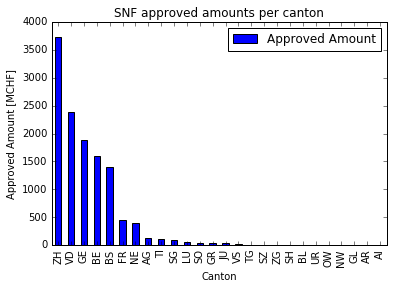

In [5]:
per_canton = df[['Canton', 'Approved Amount']].groupby('Canton').agg(sum) / 1e6 # MCHF
for canton in cantons['Name']:
    if not canton in per_canton.index:
        per_canton.loc[canton] = 0
per_canton.sort_values(by='Approved Amount', ascending=False).plot.bar()
plt.title('SNF approved amounts per canton')
plt.ylabel('Approved Amount [MCHF]')
plt.show()

## Vizualization


In [6]:
geo_path = 'data/ch-cantons.topojson.json'
data = per_canton.reset_index()
map = folium.Map(location=[46.88, 8.23],zoom_start=8)
map.choropleth(geo_path=geo_path, data_out='data1.json', data=data,
               columns=['Canton', 'Approved Amount'],
               threshold_scale=[0, 30, 120, 300, 1000, 2000],
               key_on='feature.id',
               fill_color='PuRd', fill_opacity=0.8, line_opacity=0.5,
               topojson='objects.cantons')
map.save('map.html')
map

#### DEBUG the universities' locations

In [7]:
debug = folium.Map(location=[46.798333, 8.231944],zoom_start=8)
for uni,v in locations.items():
    l = v['location']
    p = uni
    folium.Marker([l['lat'],l['lng']],popup=p).add_to(debug)
debug